In [1]:
# %%
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_wine
import optuna
from optuna.samplers import TPESampler
import pickle
import pandas as pd 
import joblib
import os, sys 
sys.path.append('/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/LightGBM')
from LightGBM_BDT_train import *

import hist
from hist import Hist
import numpy as np

In [2]:
sample_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/LightGBM/training_sample.pkl'
output_path = './inspect_best/'


In [3]:
output_folder = Path(output_path)
if not output_folder.exists():
    output_folder.mkdir(parents=True, exist_ok=True)

training_vars = ['jet_pt', 'jet_eta', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]


In [4]:
sample = pd.read_pickle(sample_path)


In [5]:
target_idx = sample.columns.get_loc('target')
y = sample.iloc[:, target_idx]
X = sample.drop(columns = 'target')

X_dev,X_test, y_dev,y_test = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [6]:
best_model = joblib.load('./lightgbm_gbdt.pkl')

In [7]:
print(best_model)

LGBMClassifier(bagging_fraction=0.9983937102708883, bagging_freq=2,
               feature_fraction=0.8145381505101543,
               lambda_l1=0.004076064447663881, lambda_l2=1.3880054955129728e-08,
               min_child_samples=18, num_leaves=239)


In [8]:
y_train_decisions = best_model.predict(X_train[training_vars], raw_score = True)
y_test_decisions = best_model.predict(X_test[training_vars], raw_score = True)

In [9]:
X_train['newGBDT_score'] = y_train_decisions
X_test['newGBDT_score'] = y_test_decisions

In [10]:
plot_ROC(y_decisions=y_test_decisions, y_tmva=X_test.iloc[:,X_test.columns.get_loc('jet_trackBDT')], 
                 y_ntrk=X_test.iloc[:,X_test.columns.get_loc('jet_nTracks')], target=y_test, 
                 X_weight=X_test['event_weight'], features=" 5 vars", output_path=output_path)

In [11]:
plot_overtraining_validation(X_dev=X_train, X_test=X_test, y_dev=y_train, y_test=y_test, 
                                    y_dev_decisions=y_train_decisions, y_test_decisions=y_test_decisions, 
                                    output_path=output_path)

In [12]:
sample_test = pd.concat((X_test, y_test), axis=1)

In [13]:
sample_1500 = sample_test.loc[sample_test['pt_idx']==5]

In [14]:
sample_1500_forward = sample_1500.loc[sample_1500['is_forward']==1]
sample_1500_central = sample_1500.loc[sample_1500['is_forward']==0]

In [15]:
bins = np.linspace(-5, 5, 101)
hist_forward = Hist(hist.axis.Regular(bins=len(bins)-1, start=bins[0], stop=bins[-1], overflow=True, underflow=True), 
                                      storage=hist.storage.Weight())
hist_central = Hist(hist.axis.Regular(bins=len(bins)-1, start=bins[0], stop=bins[-1], overflow=True, underflow=True), 
                                      storage=hist.storage.Weight())

hist_forward.fill(sample_1500_forward['newGBDT_score'], weight=sample_1500_forward['event_weight'])
hist_central.fill(sample_1500_central['newGBDT_score'], weight=sample_1500_central['event_weight'])

Hist(Regular(100, -5, 5, label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=1529.13, variance=15.9123) (WeightedSum(value=1534.39, variance=15.9517) with flow)

In [18]:
def normalize_hist(_hist):
    if _hist.sum().value != 0:
        area = np.sum(_hist.values()) * _hist.axes[0].widths
        _normed = _hist / area
    else:
        _normed = _hist
    return _normed

(([StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x154cb64a04c0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
  [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x154cb64bd910>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]),
 RatioErrorbarArtists(line=<matplotlib.lines.Line2D object at 0x154d402a1550>, errorbar=<ErrorbarContainer object of 3 artists>))

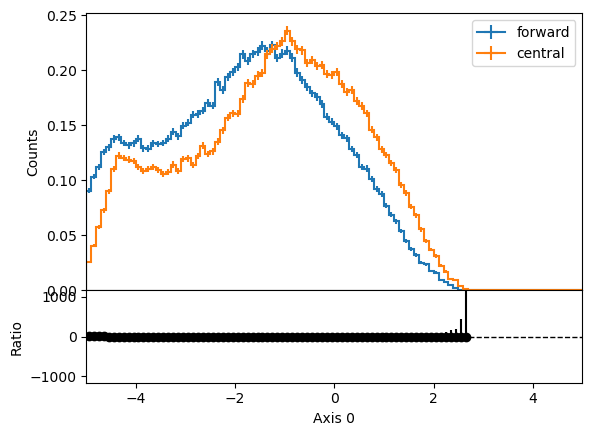

In [54]:
normalize_hist(hist_forward).plot_ratio(normalize_hist(hist_central),rp_num_label="forward",rp_denom_label="central")

In [20]:
sample_1500_forward_quark = sample_1500_forward.loc[sample_1500_forward['target']==0]
sample_1500_central_quark = sample_1500_central.loc[sample_1500_central['target']==0]

hist_forward_quark = Hist(hist.axis.Regular(bins=len(bins)-1, start=bins[0], stop=bins[-1], overflow=True, underflow=True), 
                                      storage=hist.storage.Weight())
hist_central_quark = Hist(hist.axis.Regular(bins=len(bins)-1, start=bins[0], stop=bins[-1], overflow=True, underflow=True), 
                                      storage=hist.storage.Weight())

hist_forward_quark.fill(sample_1500_forward_quark['newGBDT_score'], weight=sample_1500_forward_quark['event_weight'])
hist_central_quark.fill(sample_1500_central_quark['newGBDT_score'], weight=sample_1500_central_quark['event_weight'])


Hist(Regular(100, -5, 5, label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=1052.76, variance=10.82) (WeightedSum(value=1058, variance=10.8593) with flow)

(([StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x154cfc3c8910>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
  [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x154cb6561040>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]),
 RatioErrorbarArtists(line=<matplotlib.lines.Line2D object at 0x154cb651de80>, errorbar=<ErrorbarContainer object of 3 artists>))

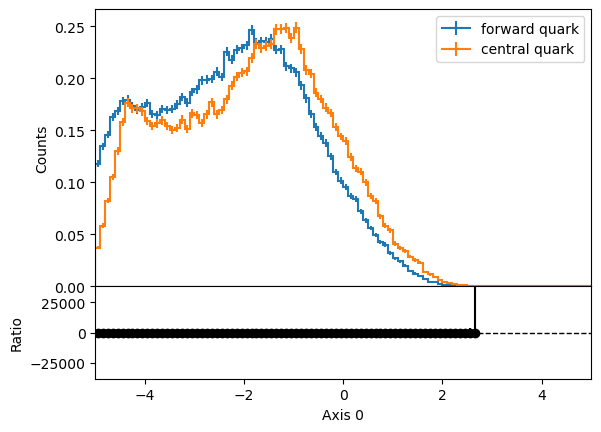

In [53]:
normalize_hist(hist_forward_quark).plot_ratio(normalize_hist(hist_central_quark), 
rp_num_label="forward quark",rp_denom_label="central quark")

In [23]:
joblib.dump(sample_test, output_folder/ 'sample_test.pkl')

['inspect_best/sample_test.pkl']